# Signal Template Matching (1-D case)


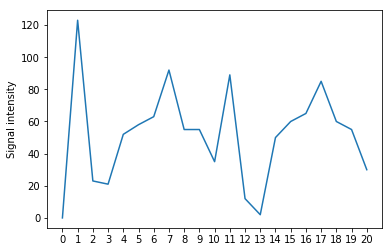

In [127]:
import matplotlib.pyplot as plt
import numpy as np

def plot_discrete(discrete_signal, label = '', show = True):
    plt.plot(discrete_signal)
    plt.ylabel(label)
    plt.xticks(np.arange(0, len(discrete_signal), 1))
    if show:
        plt.show()    

# Input signal f(j)
input_signal = np.array([0, 123, 23, 21, 52, 58, 63, 92, 55, 55, 35, 89, 12, 2, 50, 60, 65, 85, 60, 55, 30])
M = len(input_signal)
plot_discrete(input_signal, label='Signal intensity')


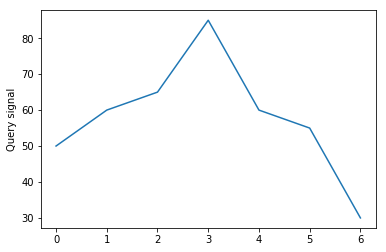

In [4]:
#Pattern signal h(j)
pattern_to_find = np.array([50, 60, 65, 85, 60, 55, 30])
N = len(pattern_to_find)
plot_discrete(pattern_to_find, label='Query signal')



## How to detect pattern entries?
Note, there are two entries of signal  

In [128]:
print(pattern_to_find) 

[50 60 65 85 60 55 30]


at position 4 and 14: 

In [6]:
print(input_signal[4:4+N])

[52 58 63 92 55 55 35]


In [129]:
print(input_signal[14:14+N])

[50 60 65 85 60 55 30]


### 1. Bruteforce approach

Run search at every point. Let's start with $s(m) = \sum\limits_{k=0}^{N-1} [f(m + k) - h(k)] ^ 2 $ :

Run search at every poi

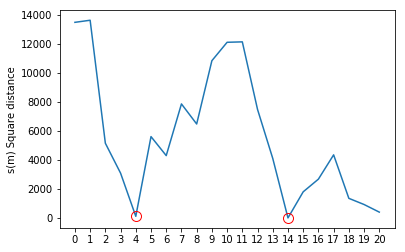

In [133]:
#Run search at every poi
h = pattern_to_find
f = input_signal
def sq(m):
    # residual length
    res = min(len(f)-m,len(h))
    return np.sum(np.square(f[m:m+res]-h[0:res]))

g_values = [sq(x) for x in range(len(f))]

plot_discrete(g_values, label='s(m) Square distance', show=False)
plt.plot(4, g_values[4], 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
plt.plot(14, g_values[14], 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
plt.show()


#### Problems?
1. Total number of calculations needed: $ O(|f|\cdot|h|) $ 
For instance, if signal $f$ has 10000 points and pattern $h$ is 100 points the will be roughly 
$ 100 \times 10000 $ summations and multiplications and even harder for 2-D case!
2. Signal is not normalized and not centered
3. Depends on scale.



### 2. Normalized Cross Correlation
First of all, let's take a look at the formula. 

$
 s(m) = \sum\limits_{k=0}^{N-1} [f(m + k) - h(k)] ^ 2 =
 \sum\limits_{k=0}^{N-1} f^2(m + k) - \sum\limits_{k=0}^{N-1} 2 f(m+k)h(k) + \sum\limits_{k=0}^{N-1} h^2(k)  
$

* $\sum\limits_{k=0}^{N-1} h^2(k)$ is constant  - ignore it
* $ \sum\limits_{k=0}^{N-1} f^2(m + k) $  - might be ignored if it's approximately constant

In other words, we might be interested only in "cross-correlation":

$ c(m) = \sum\limits_{k=0}^{N-1} f(m+k)h(k) $

Note: numpy has `np.correlate(f, h)` = $ c(m) $ 
Note: scipy has `scipy.signal.correlate(f, h)` = $ c(m) $ 

Let's plot it!


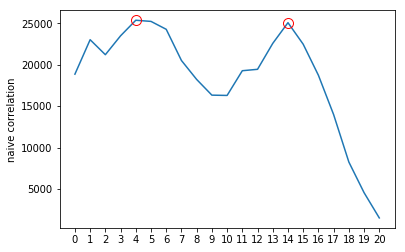

In [134]:

def cross_naive(m):
    # residual length
    res = min(len(f)-m,len(h))
    return np.dot(f[m:m+res], h[0:res])

naive_plot = [cross_naive(m) for m in range(len(f))]
plot_discrete(naive_plot, label='naive correlation', show=False)
plt.plot(4, naive_plot[4], 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
plt.plot(14, naive_plot[14], 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
plt.show()



Actual normalized cross-correlation $ \gamma(m) $ is given as: 

$ \gamma(m) =  \frac{\sum\limits_{k=0}^{N-1}\hat{f}_m(k) \times \hat{h}(k) }{ \lVert \hat{f}_m \rVert \times \lVert \hat{h} \rVert } $, where: 

$ \hat{h}(m) = h(m) - \frac{1}{N}\sum\limits_{k=0}^{N-1}h(k) $

$ \hat{f}_m(j) = f(m + j) - \frac{1}{N}\sum\limits_{k=0}^{N-1}f(m + k)  $.



C:\Anaconda\envs\p36dnn\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


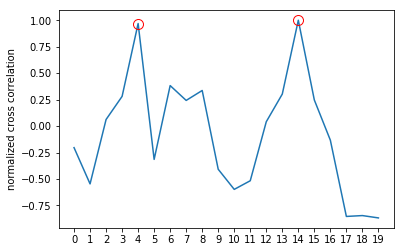

In [135]:
h_hat = h - np.average(h)
def f_hat(m):
    res = min(len(f)-m,len(h))
    f_hat_window = f[m:m+res]
    # todo:: try removing average over f_hat_window and see charts!
    return f_hat_window - np.average(f_hat_window)
    
def cross_corr_norm(m):
    f_hat_window = np.array(f_hat(m), dtype=float)
    h_hat_window = np.array(h_hat[0:len(f_hat_window)], dtype=float)
    return np.dot(f_hat_window, h_hat_window)/(np.linalg.norm(f_hat_window) * np.linalg.norm(h_hat_window))

normalized_cc_plot = [cross_corr_norm(m) for m in range(len(f))]
plot_discrete(normalized_cc_plot, label='normalized cross correlation', show=False)
plt.plot(4, normalized_cc_plot[4], 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
plt.plot(14, normalized_cc_plot[14], 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
plt.show()


### 3. Fast Normalized Cross Correlation

#### 4.1. Replace denominator with dynamic summs:

$ s(m) = f(m) + s(m-1) $

$ s^2(m) = f^2(m) + s^2(m-1) $ 

Then, "expensive" calculation becomes:

$ \hat{f}_m(j) = f(m + j) - \frac{1}{N}\sum\limits_{k=0}^{N-1}f(m + k) = f(m+j) - \frac{1}{N}(s(m + N - 1) - s(m - 1)) $

$ \lVert \hat{f}_m \rVert = ( \sum\limits_{j=0}^{N-1}\hat{f}^2_m(j))^{1/2} $

  
$ \sum\limits_{j=0}\hat{f}^2_m(j) = \sum\limits_{j=0}^{N-1}(f(m + j) - \frac{1}{N}\sum\limits_{k=0}^{N-1}f(m + k))^2 $
$  = \sum\limits_{j=0}^{N-1}f^2(m + j) - \sum\limits_{j=0}^{N-1}(2 f(m + j)\frac{1}{N}\sum\limits_{k=0}^{N-1}f(m + k)) + \sum\limits_{j=0}^{N-1}\frac{1}{N^2}(\sum\limits_{k=0}^{N-1}f(m + k))^2  $ 
$  = \sum\limits_{j=0}^{N-1}f^2(m + j) - \frac{2}{N} \sum\limits_{k=0}^{N-1}f(m + k) \times \sum\limits_{j=0}^{N-1}f(m + j) + (\sum\limits_{k=0}^{N-1}f(m + k))^2\sum\limits_{j=0}^{N-1}\frac{1}{N^2}  $
$  = \sum\limits_{j=0}^{N-1}f^2(m + j) - \frac{2}{N} (\sum\limits_{k=0}^{N-1}f(m + k))^2 + \frac{1}{N}(\sum\limits_{k=0}^{N-1}f(m + k))^2  $
$  = \sum\limits_{j=0}^{N-1}f^2(m + j) - \frac{1}{N} (\sum\limits_{k=0}^{N-1}f(m + k))^2 $
$  = \sum\limits_{j=0}^{N-1}f^2(m + j) - \frac{1}{N} (\sum\limits_{k=0}^{N-1}f(m + k))^2 $
$  = s^2(m + N - 1) - s^2(m - 1) - \frac{1}{N}(s(m + N - 1) - s(m - 1))^2  $

Let's verify this actually works!

C:\Anaconda\envs\p36dnn\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


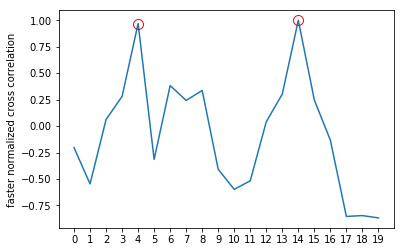

In [178]:
# yes, this approach is that popular so there's a method in numpy
f_sum = np.cumsum(f) 
f_sq_sum = np.cumsum(f ** 2)

h_sq_sum = np.cumsum(h_hat ** 2)
   
def cross_corr_norm_improved(m):
    f_hat_window = np.array(f_hat(m), dtype=float)
    h_hat_window = np.array(h_hat[0:len(f_hat_window)], dtype=float)
    top_idx = len(f_hat_window) - 1
    f_norm = f_sq_sum[m + top_idx] - (f_sq_sum[m - 1] if m > 0 else 0) - (f_sum[m + top_idx] - (f_sum[m - 1] if m > 0 else 0) )**2/(top_idx + 1)
    #centered value, so just calculating norm
    h_norm = h_sq_sum[top_idx]
    return np.dot(f_hat_window, h_hat_window)/np.sqrt(f_norm * h_norm)
  
faster_cc_plot = [cross_corr_norm_improved(m) for m in range(len(f))]

plot_discrete(faster_cc_plot, label='faster normalized cross correlation', show=False)
plt.plot(4, faster_cc_plot[4], 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
plt.plot(14, faster_cc_plot[14], 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
plt.show()


#### 4.2. Improve numerator calculation via Fourier Transform

While it was possible to calculate denominator in under $ O(M) $ operations (instead of $O(N \cdot M) $ ), 
numerator still requires calculation of dot product at every point. 
One of the approaches is to use Fourier transform to decompose dot product.


$ \sum\limits_{k=0}^{N-1}\hat{f}_m(k) \times \hat{h}(k) = \hat{f}_m * \hat{h} = \mathcal{F}^{-1}\mathcal{F}({\hat{f}_m*\hat{h})} = \mathcal{F}^{-1}(\mathcal{F}{\hat{f}_m}\mathcal{F}{\hat{h}}  )$



[-811.4285714285713, -1974.2857142857144, 150.0, 578.5714285714287, 1648.5714285714284, -632.1428571428571, 1074.2857142857142, 838.5714285714284, 978.5714285714284, -1205.7142857142858, -1819.2857142857142, -1727.142857142857, 120.71428571428578, 762.8571428571429, 1642.857142857143, 287.50000000000006, -155.0, -975.0, -208.33333333333331, -125.0, -0.0]
[-1197.85714286 -2214.79591837  -512.34693878   109.89795918
  1522.44897959  -276.02040816  1322.85714286  1131.63265306
  1156.73469388  -928.82653061 -1693.0952381  -1733.46938776
  -254.72789116   236.80272109   842.09183673   546.19047619
   434.4047619   -101.78571429   -64.88095238   -98.21428571
     0.        ]


C:\Anaconda\envs\p36dnn\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


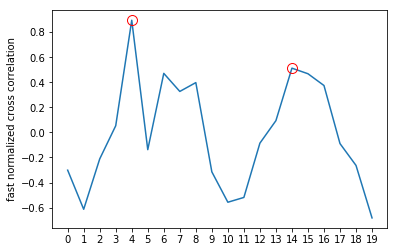

In [184]:
def f_hat_opt(m):
    res = min(len(f)-m,len(h))
    return f[m] - (f_sum[m + res - 1] - f_sum[m-1] if m > 0 else 0)/res

f_hat_opt_values = [f_hat_opt(m) for m in range(len(f))]
h_hat_opt_values = h_hat

##debug session
def cross_corr_norm_improved_num(m):
    f_hat_window = np.array(f_hat(m), dtype=float)
    h_hat_window = np.array(h_hat[0:len(f_hat_window)], dtype=float)
    return np.dot(f_hat_window, h_hat_window)

import scipy.signal as signal
# convolved_num = signal.fftconvolve(f_hat_opt_values, h_hat_opt_values[::-1])
# convolved_num = np.convolve(f_hat_opt_values, h_hat_opt_values[::-1], 'full')
convolved_num = signal.convolve(f_hat_opt_values, h_hat[::-1])[len(h_hat_opt_values)-1:]

print([cross_corr_norm_improved_num(m) for m in range(len(f_hat_opt_values))])
print(convolved_num)

def cross_corr_norm_fast(m):
    value = convolved_num[m]
    top_idx = min(len(f)-m,len(h)) - 1
    f_norm = f_sq_sum[m + top_idx] - (f_sq_sum[m - 1] if m > 0 else 0) - (f_sum[m + top_idx] - (f_sum[m - 1] if m > 0 else 0) )**2/(top_idx + 1)
    #centered value, so just calculating norm
    h_norm = h_sq_sum[top_idx]
    # return value
    return value/np.sqrt(f_norm * h_norm)


faster_cc_plot = [cross_corr_norm_fast(m) for m in range(len(f_hat_opt_values))]
plot_discrete(faster_cc_plot, label='fast normalized cross correlation', show=False)
plt.plot(4, faster_cc_plot[4], 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
plt.plot(14, faster_cc_plot[14], 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
plt.show()
